Source: This example comes from the torch adaptation of Charles Ollion [/github/charlesollion].

In [85]:

import torch
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import time
import matplotlib.pyplot as plt
import os

Data Acquisition

In [86]:
# fetch the data
csv_path = "./data/AMD_merged.csv"
df = pd.read_csv(csv_path)

# check all variables
print(df.iloc[0])

# set the date column as index for the dataframe
df["Date"] = pd.to_datetime(df["Date"])
df = df.set_index("Date")

Date                     2020-01-02
Open                      46.860001
High                          49.25
Low                       46.630001
Close                     49.099998
Volume                   80331100.0
SMA_20                      43.0105
SMA_50                      39.2072
EMA_20                     43.67221
EMA_50                    39.912493
WMA_20                    44.549191
ADX_14                    39.171538
RSI_14                    78.316758
ROC_10                    14.800089
MACD                        2.38986
MACD_signal                2.059646
MACD_hist                  0.330214
BBL                       37.095189
BBM                         43.0105
BBU                       48.925811
ATR_14                     1.419371
OBV                    1818999400.0
MFI_14                     84.67671
CMF_20                     0.172622
 Gold_Open                   1524.5
 Gold_High              1528.699951
 Gold_Low                    1518.0
 Gold_Close             1518

Data preprocessing
- Log-transform the suitable features
- Save the features to be normalized separately for each data split

In [87]:
df_stationary = df.copy()
df_stationary.columns = df_stationary.columns.str.strip() # remove any white spaces from start and end


'''
for col in df_stationary.columns[:-1]:
    min_val = df_stationary[col].min()
    
    if col in [*featuresToNormalizeSeparately, "Close"]:
        # The Close price will be predicted and it will be used without
        # the log-transformation.
        #
        # Normalize the other columns wihtout log returns since they are not
        # price type of data. The normalization need to be done for the
        # traing/validation and testing separately since we can not let the
        # statistics of test set to influence the models training data.
        print("skip this ", col)
        print(df_stationary["Close"].iloc[0])

        continue

    if min_val <= 0.001:
        if min_val >= -0.001:
            # if the negative values are very small, just clip them to close zero
            # this allows the division and log to work
            df_stationary[col] = df_stationary[col].clip(lower=0.001)
            
        else:
            # otherwice move the values to positive range
            df_stationary[col] = df_stationary[col] - min_val + 0.001
            print(col, " moved to positive range.")

    # Compute log returns
    # MIN-MAX normalization
    df_stationary[col] = np.log(df_stationary[col] / df_stationary[col].shift(1))
    df_stationary.columns    
'''

# add price log-returns to the data
addTheseAsLogReturns = ["Close", "High", "Open", "Low"]
for col in addTheseAsLogReturns:
    df_stationary["%s_log_returns" % col] = np.log(df_stationary[col] / df_stationary[col].shift(1))



# Drop the possible NaN containing rows
df_stationary = df_stationary.dropna()

# move the target column "Close" to last in dataframe
col = "Close"
df_stationary = df_stationary[[c for c in df_stationary.columns if c != col] + [col]]


if df_stationary.isnull().values.any():
    print("HAS NAN VALUES")

# if the data has no variation drop
for col in df_stationary.columns:
    if abs(np.min(df_stationary[col]) - np.max(df_stationary[col])) < 0.01:
        df_stationary.drop([col], axis=1, inplace=True)
        print("Dropped : ", col)


Dropped :  VIX_Volume
Dropped :  Treasury10Y_Volume
Dropped :  USD_Index_Volume


In [88]:
# How much history is provided for the model to predict from
inputLength = 30

# check the dimensionality of the data
inputFeaturesNum = df_stationary.shape[1]


In [89]:
# separate folds data
df_fold1 = df_stationary.loc[:"2021-03-31"].copy()
df_fold2 = df_stationary.loc[:"2022-12-30"].copy()
df_fold3 = df_stationary.loc[:"2023-12-29"].copy()
df_fold4 = df_stationary.copy()
del df_stationary # no longer needed.

Function for splitting the dataset into training and validation, and rest of data normalization.

In [90]:
def partition(data, pTrain=0.7, pVal = 0.5, save_path=None):
    ######
    # Here we normalize the data before the division to the sequences
    #####
    n = len(data)
    split_idx = int(n * 0.7)

    # from training data
    train = data.iloc[:split_idx]
    train_min = train.min()
    train_max = train.max()

    data_normalized = data.copy()
    
    # Apply min-max normalization to all columns except log returns
    for col in data.columns:
        if not col.endswith("_log_returns"):
            # Avoid division by zero
            denominator = train_max[col] - train_min[col]
            if denominator == 0:
                print(f"Warning: Column {col} has zero range, skipping normalization")
                data_normalized[col] = 0.0
            else:
                data_normalized[col] = (data[col] - train_min[col]) / denominator
                
                # Clip values in case of outliers
                data_normalized[col] = data_normalized[col].clip(-5, 5)
    
    # save min/max for the target variable
    close_min = train_min["Close"]
    close_max = train_max["Close"]
    normalization_constants = [close_min,close_max]

    if data.isnull().values.any():
        print("HAS NAN VALUES")

    sequencedData = sequencing(data_normalized, start_index=0, end_index=None, history_size=inputLength, step=1)

    # No shuffle for the sequential data which has strict time dependency
    dataTrain, dataVal = train_test_split(sequencedData, train_size=pTrain, shuffle=False, random_state=123)
    dataVal, dataTest = train_test_split(dataVal, train_size=pVal, shuffle=False, random_state=123)

    return dataTrain, dataVal, dataTest, normalization_constants

Function for splitting the dataset into sequences of observations of length history size.

In [91]:
def sequencing(dataset, start_index=0, end_index=None, history_size=inputLength, step=1):
    data = []
    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset)
    for i in range(start_index, end_index):
        indices = range(i - history_size, i, step)
        data.append(dataset.iloc[indices])
    return np.array(data)


Create input-putput pairs.

In [92]:
def split(chunk):
    inputs = torch.tensor(chunk[:, :-1, :],dtype=torch.float32, device=device) # What about that device?
    targets = torch.tensor(chunk[:, 1:, :],dtype=torch.float32, device=device)
    return inputs, targets

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Loaders

In [93]:
def createLoaders(dataTrain, dataVal, dataTest, batchSize=32, responseVariables=-1):
    XTrain, YTrain = split(dataTrain)
    XVal, YVal = split(dataVal)
    XTest, YTest = split(dataTest)

    # keep only the target variables from y data
    YTrain = YTrain[:,:,[responseVariables]]
    YVal = YVal[:,:,[responseVariables]]
    YTest = YTest[:,:,[responseVariables]]

    trainDS = torch.utils.data.TensorDataset(XTrain, YTrain)
    valDS = torch.utils.data.TensorDataset(XVal, YVal)
    testDS = torch.utils.data.TensorDataset(XTest, YTest)

    trainLoader = torch.utils.data.DataLoader(trainDS, batch_size=batchSize)
    valLoader = torch.utils.data.DataLoader(valDS, batch_size=batchSize)
    testLoader = torch.utils.data.DataLoader(testDS, batch_size=batchSize)

    return trainLoader, valLoader, testLoader

trainData, valData, testData, normalization_constants1 = partition(df_fold1)
trainDatasetF1, valDatasetF1, testDatasetF1 = createLoaders(trainData, valData, testData)

trainData, valData, testData, normalization_constants2 = partition(df_fold2)
trainDatasetF2, valDatasetF2, testDatasetF2 = createLoaders(trainData, valData, testData)

trainData, valData, testData, normalization_constants3 = partition(df_fold3)
trainDatasetF3, valDatasetF3, testDatasetF3 = createLoaders(trainData, valData, testData)

trainData, valData, testData, normalization_constants4 = partition(df_fold4)
trainDatasetF4, valDatasetF4, testDatasetF4 = createLoaders(trainData, valData, testData)

dataFolds = [
    (trainDatasetF1, valDatasetF1, testDatasetF1),
    (trainDatasetF2, valDatasetF2, testDatasetF2),
    (trainDatasetF3, valDatasetF3, testDatasetF3),
    (trainDatasetF4, valDatasetF4, testDatasetF4)
]

Transformer NN implementation

In [94]:
import torch.nn as nn
import math

class MultiHeadAttention(nn.Module):
    def __init__(self, D, H):
        super(MultiHeadAttention, self).__init__()
        self.H = H # number of heads
        self.D = D # dimension
        
        self.wq = nn.Linear(D, D*H)
        self.wk = nn.Linear(D, D*H)
        self.wv = nn.Linear(D, D*H)

        self.dense = nn.Linear(D*H, D)

    def concat_heads(self, x):
        '''(B, H, S, D) => (B, S, D*H)'''
        B, H, S, D = x.shape
        x = x.permute((0, 2, 1, 3)).contiguous()  # (B, S, H, D)
        x = x.reshape((B, S, H*D))   # (B, S, D*H)
        return x

    def split_heads(self, x):
        '''(B, S, D*H) => (B, H, S, D)'''
        B, S, D_H = x.shape
        x = x.reshape(B, S, self.H, self.D)    # (B, S, H, D)
        x = x.permute((0, 2, 1, 3))  # (B, H, S, D)
        return x

    def forward(self, x, mask):

        q = self.wq(x)  # (B, S, D*H)
        k = self.wk(x)  # (B, S, D*H)
        v = self.wv(x)  # (B, S, D*H)

        q = self.split_heads(q)  # (B, H, S, D)
        k = self.split_heads(k)  # (B, H, S, D)
        v = self.split_heads(v)  # (B, H, S, D)

        attention_scores = torch.matmul(q, k.transpose(-1, -2)) #(B,H,S,S)
        attention_scores = attention_scores / math.sqrt(self.D)

        # add the mask to the scaled tensor.
        if mask is not None:
            attention_scores += (mask * -1e9)
        
        attention_weights = nn.Softmax(dim=-1)(attention_scores)
        scaled_attention = torch.matmul(attention_weights, v)  # (B, H, S, D)
        concat_attention = self.concat_heads(scaled_attention) # (B, S, D*H)
        output = self.dense(concat_attention)  # (B, S, D)

        return output, attention_weights

In [95]:
B, S, H, D = 9, inputLength, 4, 32
mha = MultiHeadAttention(D, H)
out, att = mha.forward(torch.zeros(B, S, D), mask=None)
out.shape, att.shape

(torch.Size([9, 30, 32]), torch.Size([9, 4, 30, 30]))

In [96]:
# Positional encodings
def get_angles(pos, i, D):
    angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(D))
    return pos * angle_rates


def positional_encoding(D, position=inputLength-1, dim=3, device=device):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                            np.arange(D)[np.newaxis, :],
                            D)
    # apply sin to even indices in the array; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    # apply cos to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    if dim == 3:
        pos_encoding = angle_rads[np.newaxis, ...]
    elif dim == 4:
        pos_encoding = angle_rads[np.newaxis,np.newaxis,  ...]
    return torch.tensor(pos_encoding, device=device)

# function that implement the look_ahead mask for masking future time steps. 
def create_look_ahead_mask(size, device=device):
    mask = torch.ones((size, size), device=device)
    mask = torch.triu(mask, diagonal=1)
    return mask  # (size, size)

create_look_ahead_mask(inputLength)

class TransformerLayer(nn.Module):
    def __init__(self, D, H, hidden_mlp_dim, dropout_rate):
        super(TransformerLayer, self).__init__()
        self.dropout_rate = dropout_rate
        self.mlp_hidden = nn.Linear(D, hidden_mlp_dim)
        self.mlp_out = nn.Linear(hidden_mlp_dim, D)
        self.layernorm1 = nn.LayerNorm(D, eps=1e-9)
        self.layernorm2 = nn.LayerNorm(D, eps=1e-9)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.dropout2 = nn.Dropout(dropout_rate)

        self.mha = MultiHeadAttention(D, H)

    def forward(self, x, look_ahead_mask):
        
        attn, attn_weights = self.mha(x, look_ahead_mask)  # (B, S, D)
        attn = self.dropout1(attn) # (B,S,D)
        attn = self.layernorm1(attn + x) # (B,S,D)

        mlp_act = torch.relu(self.mlp_hidden(attn))
        mlp_act = self.mlp_out(mlp_act)
        mlp_act = self.dropout2(mlp_act)
        
        output = self.layernorm2(mlp_act + attn)  # (B, S, D)

        return output, attn_weights

In [97]:
dl = TransformerLayer(16, 3, 32, 0.1)
out, attn = dl(x=torch.zeros(5, 7, 16), look_ahead_mask=None)
out.shape, attn.shape

(torch.Size([5, 7, 16]), torch.Size([5, 3, 7, 7]))

In [98]:
class Transformer(nn.Module):
    '''Transformer Decoder Implementating several Decoder Layers.
    '''
    def __init__(self, num_layers, D, H, hidden_mlp_dim, inp_features, out_features, dropout_rate):
        super(Transformer, self).__init__()
        self.sqrt_D = torch.tensor(math.sqrt(D))
        self.device = device
        self.num_layers = num_layers
        self.D = D
        self.H = H
        self.hidden_mlp_dim = hidden_mlp_dim
        self.inp_features = inp_features
        self.out_features = out_features
        self.dropout_rate = dropout_rate
        self.input_projection = nn.Linear(inp_features, D) # multivariate input
        self.output_projection = nn.Linear(D, out_features) # multivariate output
        self.pos_encoding = positional_encoding(D)
        self.dec_layers = nn.ModuleList([TransformerLayer(D, H, hidden_mlp_dim, 
                                        dropout_rate=dropout_rate
                                       ) for _ in range(num_layers)])
        self.dropout = nn.Dropout(dropout_rate)

    @property
    def init_args(self):
        """Returns the positional arguments needed to re-instantiate the model."""
        return (
            self.num_layers,
            self.D,
            self.H,
            self.hidden_mlp_dim,
            self.inp_features,
            self.out_features,
            self.dropout_rate
        )
    
    def forward(self, x, mask):
        B, S, D = x.shape
        attention_weights = {}
        x = self.input_projection(x)
        x *= self.sqrt_D
        
        x += self.pos_encoding[:, :S, :]

        x = self.dropout(x)

        for i in range(self.num_layers):
            x, block = self.dec_layers[i](x=x,
                                          look_ahead_mask=mask)
            attention_weights['decoder_layer{}'.format(i + 1)] = block
        
        x = self.output_projection(x)
        
        return x, attention_weights # (B,S,S)

In [99]:
#print(targets[0].shape)
#print(inputs[0].shape)

In [100]:
# Test Forward pass on the Transformer:
transformer_1 = Transformer(num_layers=1, D=D, H=H, hidden_mlp_dim=32,
                                       inp_features=inputFeaturesNum, out_features=1, dropout_rate=0.1).to(device)
transformer_1.to(device)
(inputs, targets) = next(iter(trainDatasetF1))
                         
S = inputs.shape[1]
mask = create_look_ahead_mask(S)
out, attn = transformer_1(x=inputs, mask=mask)
out.shape, attn["decoder_layer1"].shape

(torch.Size([32, 29, 1]), torch.Size([32, 4, 29, 29]))

In [101]:
# What size is the model:
param_sizes = [p.numel() for p in transformer_1.parameters()]
print(f"number of weight/biases matrices: {len(param_sizes)} "
      f"for a total of {np.sum(param_sizes)} parameters ")

number of weight/biases matrices: 20 for a total of 20993 parameters 


Training the Transformer

In [102]:
# model with conservative learning rate and simple architechture
transformer_1 = Transformer(num_layers=1, D=32, H=4, hidden_mlp_dim=32,
                          inp_features=inputFeaturesNum, out_features=1, dropout_rate=0.1).to(device)
optimizer_1 = torch.optim.RMSprop(transformer_1.parameters(), 
                                lr=0.00005)

# same model as before but with larger learning rate
transformer_2 = Transformer(num_layers=1, D=32, H=4, hidden_mlp_dim=32,
                          inp_features=inputFeaturesNum, out_features=1, dropout_rate=0.1).to(device)
optimizer_2 = torch.optim.RMSprop(transformer_2.parameters(), 
                                lr=0.0001)

# model with larger architechture
transformer_3 = Transformer(num_layers=2, D=64, H=8, hidden_mlp_dim=64,
                          inp_features=inputFeaturesNum, out_features=1, dropout_rate=0.1).to(device)
optimizer_3 = torch.optim.RMSprop(transformer_3.parameters(), 
                                lr=0.00005)

optimizer = [optimizer_1, optimizer_2, optimizer_3]
transformers = [transformer_1, transformer_2, transformer_3]

In [103]:
modelNames = []
for i in range(len(dataFolds)):
    for j in range(len(transformers)):
        modelNames.append("best_model%d_for_fold%d" % (i+1,j+1))
        
PLOTS_DIR = "fig"
MODELS_DIR = "trained_models"
if not os.path.exists(MODELS_DIR):
    os.makedirs(MODELS_DIR)

In [ ]:

from tqdm import tqdm

n_epochs = 2500
patience = 35 # how easily training gets cut off



# loop for different folds in the data
for i, (trainDataset, valDataset, _) in enumerate(dataFolds):
    # losses for three models
    losses, val_losses = [[],[],[]], [[],[],[]]
    niter = len(trainDataset)
    # loop for different models to be tested
    for j, transformer in enumerate(transformers):
        transformer.to(device)
        best_val_loss = float('inf')
        for e in tqdm(range(n_epochs)):
            
            # one epoch on train set
            transformer.train()
            sum_train_loss = 0.0
            for x,y in trainDataset:
                #optimizer[i].zero_grad()
                S = x.shape[1]
                mask = create_look_ahead_mask(S)
                out, _ = transformer(x, mask)

                # loss for the whole output
                #loss = torch.nn.MSELoss()(out, y)
                
                # Calculates error only for the final prediction
                loss = torch.nn.MSELoss()(out[:, -1, :], y[:, -1, :])

                sum_train_loss += loss.item()
                loss.backward()
                # gradient clip
                torch.nn.utils.clip_grad_norm_(transformer.parameters(), max_norm=1.0)
                optimizer[j].step()
            losses[j].append(sum_train_loss / niter)
            
            # Evaluate on val set
            transformer.eval()
            sum_val_loss = 0.0
            for k, (x, y) in enumerate(valDataset):
                S = x.shape[1]
                mask = create_look_ahead_mask(S)
                out, _ = transformer(x, mask)

                # loss for the whole output
                #loss = torch.nn.MSELoss()(out, y)

                # loss for only the coming day close prise
                loss = torch.nn.MSELoss()(out[:, -1, :], y[:, -1, :])
                sum_val_loss += loss.item()
            val_losses[j].append(sum_val_loss / (k + 1))


            # Early stopping
            if val_losses[j][-1] < best_val_loss:
                best_val_loss = val_losses[j][-1]
                patience_counter = 0
                # Save the best model
                save_filename = os.path.join(MODELS_DIR, "best_model_fold%d_transformer%d.pth" % (i+1, j+1)) # Define filename
                torch.save(transformer.state_dict(), save_filename)
            else:
                patience_counter += 1
            
            if patience_counter >= patience:
                if e < 50:
                    continue
                print(f"\nEarly stopping at epoch {e+1}")
                print(f"Best validation loss: {best_val_loss:.6f}")

                break
        

        plt.plot(losses[j])
        plt.plot(val_losses[j])
        plt.legend(["train loss", "validation loss"])
        plt.title("Transformer %d; Fold %d" % (j+1, i+1))
        save_filename = os.path.join(PLOTS_DIR, "Model%d_fold%d.png" % (j+1,i+1)) # Define filename
        plt.savefig(save_filename, dpi=300)
        plt.clf()



100%|██████████| 2/2 [00:00<00:00,  9.85it/s]

100%|██████████| 2/2 [00:00<00:00, 11.38it/s]

100%|██████████| 2/2 [00:00<00:00,  5.89it/s]

100%|██████████| 2/2 [00:02<00:00,  1.31s/it]



<Figure size 640x480 with 0 Axes>

In [105]:
## Evaluation of all models on their respective test sets

# Store all normalization constants
normalization_constants_list = [normalization_constants1, normalization_constants2, 
                                 normalization_constants3, normalization_constants4]

# Store results: [num_models, num_folds]
all_test_mse_results = np.zeros((len(transformers), len(dataFolds)))

# We need to re-iterate through the data folds and models to load and test each one.
for i, (_, _, testDataset) in enumerate(dataFolds): # i = fold index, we only need testDataset
    
    # We assume 'transformers' is a list of UNTRAINED models used only to get the architecture
    for j, transformer in enumerate(transformers): # j = model index
        
        # 1. Load the Best Model Parameters
        load_filename = os.path.join(MODELS_DIR, f"best_model_fold{i+1}_transformer{j+1}.pth")
        
        # Create a fresh model instance (clone the template)
        # Assuming transformers[j] is the template model
        model = type(transformer)(*transformer.init_args).to(device) # Replace with your actual model instantiation
        
        try:
            model.load_state_dict(torch.load(load_filename))
        except FileNotFoundError:
            print(f"ERROR: Model file {load_filename} not found. Skipping.")
            continue
        
        model.eval()
        
        # 2. Evaluation Setup (Similar to your example, but isolated)
        sum_test_loss_normalized = 0.0
        all_predictions_normalized = []
        all_true_values_normalized = []
        
        with torch.no_grad():
            for inputs, targets in testDataset:
                S = inputs.shape[1]
                mask = create_look_ahead_mask(S)
                
                out, _ = model(x=inputs, mask=mask)
                
                # Normalized Loss and Prediction
                loss = torch.nn.MSELoss()(out[:, -1, :], targets[:, -1, :])
                sum_test_loss_normalized += loss.item()
                
                batch_predictions = out[:, -1, :].cpu().numpy().flatten()
                all_predictions_normalized.extend(batch_predictions)

                batch_true_values = targets[:, -1, :].cpu().numpy().flatten()
                all_true_values_normalized.extend(batch_true_values)

        # 3. Denormalize and Calculate Final MSE
        close_min, close_max = normalization_constants_list[i]
        
        true_values_denormalized = np.array(all_true_values_normalized) * (close_max - close_min) + close_min
        predictions_denormalized = np.array(all_predictions_normalized) * (close_max - close_min) + close_min
        
        # Calculate Denormalized MSE
        denormalized_mse = np.mean((predictions_denormalized - true_values_denormalized)**2)
        
        # Store result in the global storage array
        all_test_mse_results[j, i] = denormalized_mse
        
        print(f"Fold {i+1}, Transformer {j+1}: Denormalized MSE = {denormalized_mse:.2f}")

Fold 1, Transformer 1: Denormalized MSE = 62.44
Fold 1, Transformer 2: Denormalized MSE = 20.78
Fold 1, Transformer 3: Denormalized MSE = 84.19
Fold 2, Transformer 1: Denormalized MSE = 704.57
Fold 2, Transformer 2: Denormalized MSE = 409.84
Fold 2, Transformer 3: Denormalized MSE = 140.26
Fold 3, Transformer 1: Denormalized MSE = 157.04
Fold 3, Transformer 2: Denormalized MSE = 253.45
Fold 3, Transformer 3: Denormalized MSE = 498.76
Fold 4, Transformer 1: Denormalized MSE = 644.69
Fold 4, Transformer 2: Denormalized MSE = 678.79
Fold 4, Transformer 3: Denormalized MSE = 435.77
Fold 3, Transformer 3: Denormalized MSE = 498.76
Fold 4, Transformer 1: Denormalized MSE = 644.69
Fold 4, Transformer 2: Denormalized MSE = 678.79
Fold 4, Transformer 3: Denormalized MSE = 435.77


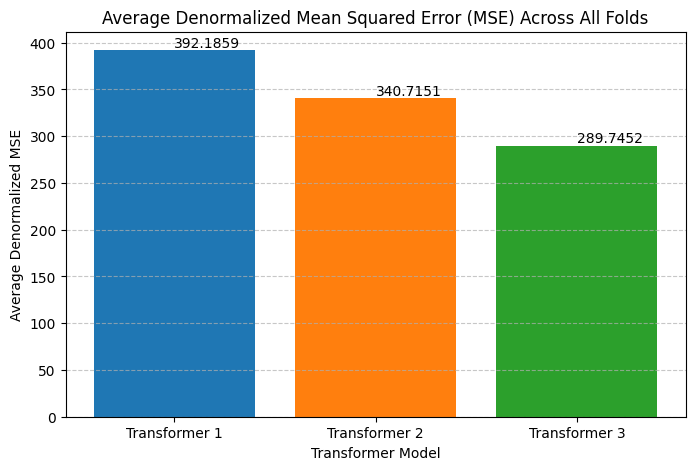

In [106]:
# Calculate average MSE per model across all folds
avg_mse_per_model = np.mean(all_test_mse_results, axis=1)
model_names = ["Transformer 1", "Transformer 2", "Transformer 3"]

# Create one picture which has the barplot for all the models (averaged over folds)
plt.figure(figsize=(8, 5))
bars = plt.bar(model_names, avg_mse_per_model, color=['#1f77b4', '#ff7f0e', '#2ca02c'])
plt.title('Average Denormalized Mean Squared Error (MSE) Across All Folds')
plt.xlabel('Transformer Model')
plt.ylabel('Average Denormalized MSE')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add MSE values on top of the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, f'{yval:.4f}', va='bottom') # Center the text
    
plt.savefig("all_models_average_test_mse_barplot.png", dpi=300)
plt.show()


--- Test Set Performance ---
Transformer 1:
  Normalized MSE: 0.040912
  Denormalized MSE: 644.69
Transformer 2:
  Normalized MSE: 0.043401
  Denormalized MSE: 678.79
Transformer 3:
  Normalized MSE: 0.024723
  Denormalized MSE: 389.65


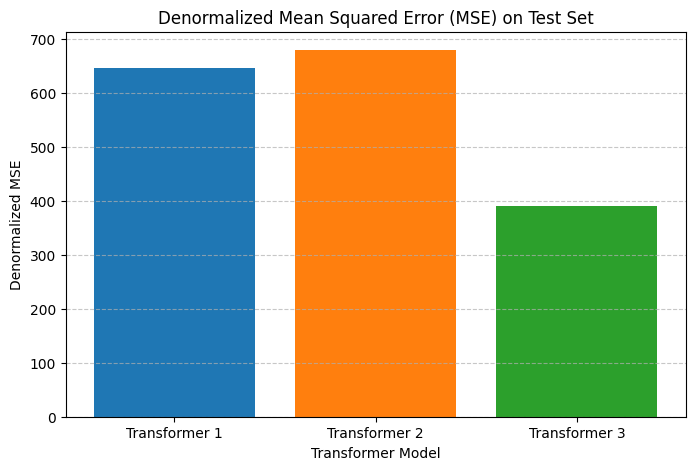

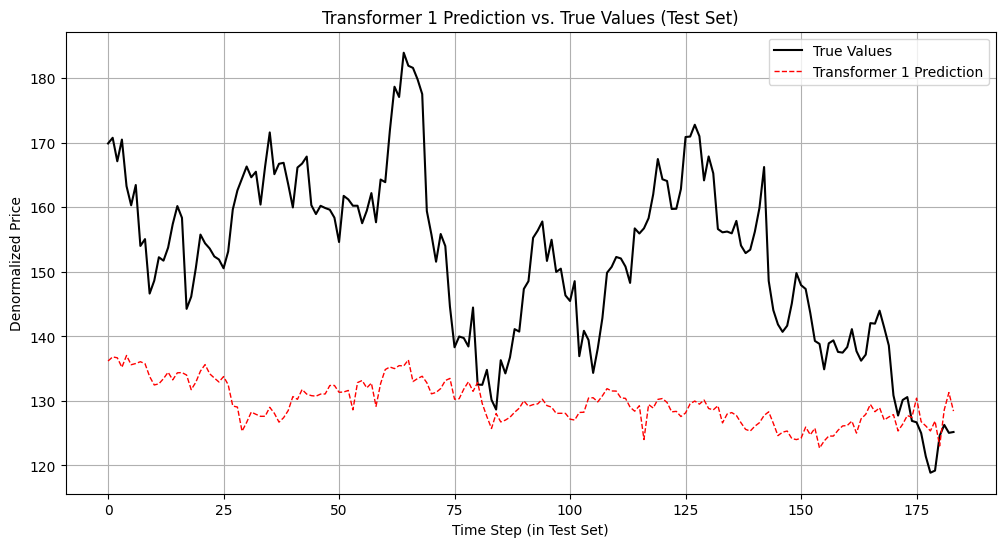

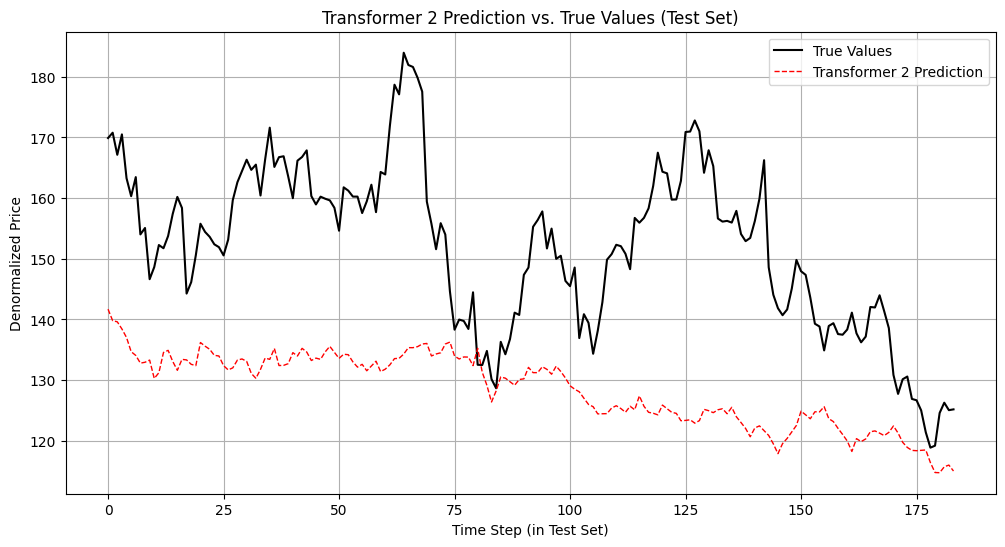

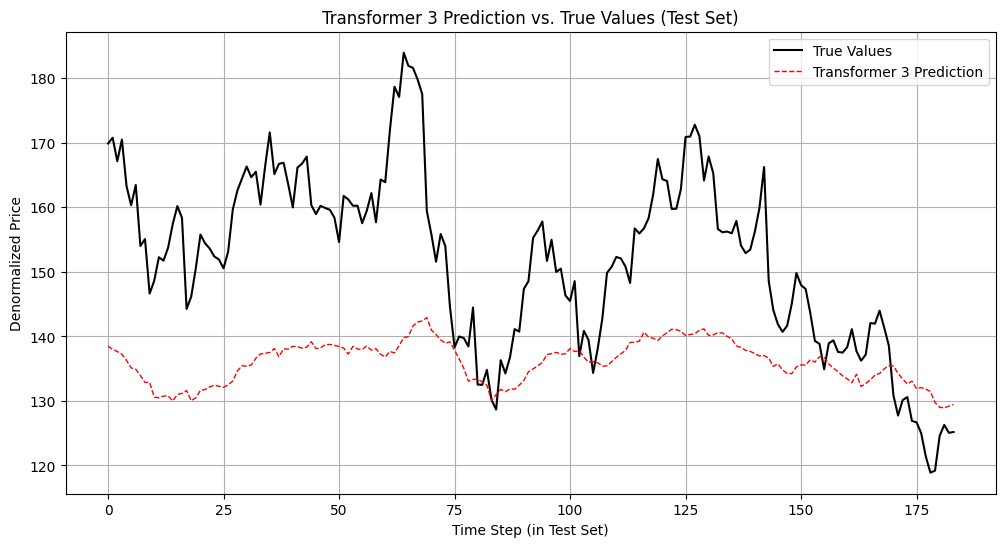

In [108]:

model_names = ["Transformer 1", "Transformer 2", "Transformer 3"]

# Losses and predictions lists and arrays
# Sum of MSE loss for each model across all test batches
sum_test_loss = np.zeros(len(transformers)) 
# Denormalized predictions for each model (list of lists)
all_predictions = [[] for _ in range(len(transformers))]
# denormalized true values
all_true_values = []
# loss function
mse_loss_fn = torch.nn.MSELoss()

# Evaluation
for inputs, targets in testDataset:
    
    # All models to evaluation mode
    for transformer in transformers:
        transformer.eval()
        
    S = inputs.shape[1]
    mask = create_look_ahead_mask(S)    
    
    # Prediction and Loss Calculation (Normalized)
    for j, transformer in enumerate(transformers):
        with torch.no_grad(): # Disable gradient calculation
            out, _ = transformer(x=inputs, mask=mask)
            # loss
            loss = mse_loss_fn(out[:, -1, :], targets[:, -1, :])
            sum_test_loss[j] += loss.item()
            
            # Pick prediction for the last step
            batch_predictions = out[:, -1, :].cpu().numpy().flatten()
            all_predictions[j].extend(batch_predictions)

    # 2. True Values Storage (Normalized)
    # Pick the true values for the last time step from the targets
    batch_true_values = targets[:, -1, :].cpu().numpy().flatten()
    all_true_values.extend(batch_true_values)

# normalized MSE
num_batches = len(testDataset)
avg_normalized_mse = sum_test_loss / num_batches

# Reverse Min-Max Normalization for final metrics and plotting
normalization_constants = normalization_constants4
close_min, close_max = normalization_constants[0], normalization_constants[1]

# Denormalize True Values
true_values_denormalized = np.array(all_true_values) * (close_max - close_min) + close_min

# Denormalize Predictions and calculate true MSE without the normalization effect
final_mse_denormalized = np.zeros(len(transformers))
denormalized_predictions_storage = [] # Storage for the new plots

for j in range(len(transformers)):
    # Denormalize predictions
    predictions_denormalized = np.array(all_predictions[j]) * (close_max - close_min) + close_min
    denormalized_predictions_storage.append(predictions_denormalized) # Store for individual plotting
    
    # Calculate Denormalized MSE
    final_mse_denormalized[j] = np.mean((predictions_denormalized - true_values_denormalized)**2)

# Output
print("\n--- Test Set Performance ---")
for i, name in enumerate(model_names):
    print(f"{name}:")
    print(f"  Normalized MSE: {avg_normalized_mse[i]:.6f}")
    print(f"  Denormalized MSE: {final_mse_denormalized[i]:.2f}")

plt.figure(figsize=(8, 5))
plt.bar(model_names, final_mse_denormalized, color=['#1f77b4', '#ff7f0e', '#2ca02c'])
plt.title('Denormalized Mean Squared Error (MSE) on Test Set')
plt.xlabel('Transformer Model')
plt.ylabel('Denormalized MSE')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# plot against th etrue values
num_predictions = len(true_values_denormalized)
x_axis = np.arange(num_predictions) # Use an index for the x-axis

for j, name in enumerate(model_names):
    predictions_denormalized = denormalized_predictions_storage[j]
    
    plt.figure(figsize=(12, 6))
    
    # Plot True Values 
    plt.plot(x_axis, true_values_denormalized, label='True Values', color='black', linewidth=1.5)
    
    # Plot Predictions for the current model
    plt.plot(x_axis, predictions_denormalized, label=f'{name} Prediction', color='red', linestyle='--', linewidth=1)
    
    plt.title(f'{name} Prediction vs. True Values (Test Set)')
    plt.xlabel('Time Step (in Test Set)')
    plt.ylabel('Denormalized Price')
    plt.legend()
    plt.grid(True)
    plt.show()